In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score as cv_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

#### Executive Summary

- Performance
These performance estimates are generated from cross validation, which should be a reasonable approximation of the expected test set performance. Looking at ROC AUC alone, the calibrated logistic regression model did reasonably well.

| Model | Regression |
| --- | --- |
| ROC AUC | 0.662 |

- Method
The trained model is a calibrated logistic regression model with a ridge (L2) penalty and Platt scaling for calibration of probabilities. Performances were compared using 5 fold cross validation.

- Caveat
There was no column denoting the relative time of each row. There is a concern that the cross validation results are biased as time series cross validation was not used. There was no way to ensure that there is no temporal data leakage across validation splits or between the train and test data.

#### Data Exploration

In [2]:
DATA_PATH = "./data/"
data = pd.read_csv(DATA_PATH + "DS_Work_Sample_Data.csv")
data["sample"].value_counts()

sample
Train      40000
Holdout    20000
Name: count, dtype: int64

In [3]:
data_tr = data.loc[data["sample"] == "Train", ].copy().reset_index()
data_te = data.loc[data["sample"] == "Holdout", ].copy().reset_index()
data_tr.describe()

,index,Unnamed: 0,plcy_id,curnt_bi_low,curnt_bi_upp,curnt_pd_lmt,curnt_coll_ded,curnt_comp_ded,hh_veh_cnt,hh_cnt_auto,...,hh_atf_clm_cnt_py2,hh_atf_clm_cnt_py3,hh_atf_clm_cnt_py4,hh_atf_clm_cnt_py5,hh_naf_clm_cnt_py1,hh_naf_clm_cnt_py2,hh_naf_clm_cnt_py3,hh_naf_clm_cnt_py4,hh_naf_clm_cnt_py5,future_clm_ind
count,40000.00000,40000.00000,40000.00000,40000.000000,40000.000000,40000.000000,30312.000000,27625.000000,40000.000000,40000.000000,...,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,19999.50000,19999.50000,20000.50000,98707.500000,193905.000000,73648.375000,802.215294,387.400905,1.727775,1.683225,...,0.126025,0.187825,0.236950,0.281525,0.047500,0.105450,0.161050,0.211775,0.255575,0.061700
std,11547.14972,11547.14972,11547.14972,92506.822081,138671.218058,75478.630489,575.719460,337.091688,1.074150,1.037741,...,0.372285,0.471966,0.544024,0.610269,0.225044,0.345519,0.440191,0.526719,0.598469,0.240613
min,0.00000,0.00000,1.00000,25000.000000,50000.000000,20000.000000,250.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9999.75000,9999.75000,10000.75000,25000.000000,50000.000000,25000.000000,250.000000,250.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,19999.50000,19999.50000,20000.50000,50000.000000,100000.000000,50000.000000,500.000000,250.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,29999.25000,29999.25000,30000.25000,100000.000000,300000.000000,100000.000000,1000.000000,500.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,39999.00000,39999.00000,40000.00000,750000.000000,1000000.000000,300000.000000,2000.000000,2000.000000,11.000000,10.000000,...,6.000000,7.000000,7.000000,6.000000,3.000000,5.000000,6.000000,6.000000,7.000000,1.000000


In [4]:
data_tr.dtypes, data_te.dtypes

(index                   int64
 Unnamed: 0              int64
 plcy_id                 int64
 sample                 object
 curnt_bi_low            int64
 curnt_bi_upp            int64
 curnt_pd_lmt            int64
 curnt_coll_ded        float64
 curnt_comp_ded        float64
 hh_veh_cnt              int64
 hh_cnt_auto             int64
 hh_cnt_mtrcyc           int64
 hh_veh_w_coll_cnt       int64
 hh_veh_w_comp_cnt       int64
 hh_veh_lien_cnt       float64
 hh_veh_lease_cnt      float64
 hh_veh_own_cnt        float64
 veh_ownership          object
 annual_mileage        float64
 veh_make               object
 veh_model              object
 veh_age               float64
 min_hh_veh_age        float64
 max_hh_veh_age        float64
 avg_hh_veh_age        float64
 hh_drvr_cnt           float64
 hh_min_age            float64
 hh_max_age            float64
 hh_avg_age            float64
 hh_min_mon_lic        float64
 hh_max_mon_lic        float64
 hh_avg_mon_lic        float64
 hh_cnt_

In [5]:
# Check if data is missing.
data_tr.isnull().sum(), data_te.isnull().sum()

(index                     0
 Unnamed: 0                0
 plcy_id                   0
 sample                    0
 curnt_bi_low              0
 curnt_bi_upp              0
 curnt_pd_lmt              0
 curnt_coll_ded         9688
 curnt_comp_ded        12375
 hh_veh_cnt                0
 hh_cnt_auto               0
 hh_cnt_mtrcyc             0
 hh_veh_w_coll_cnt         0
 hh_veh_w_comp_cnt         0
 hh_veh_lien_cnt        5184
 hh_veh_lease_cnt       5184
 hh_veh_own_cnt         5184
 veh_ownership          4578
 annual_mileage         1293
 veh_make                  0
 veh_model                 0
 veh_age                   0
 min_hh_veh_age            0
 max_hh_veh_age            0
 avg_hh_veh_age            0
 hh_drvr_cnt               0
 hh_min_age                0
 hh_max_age                0
 hh_avg_age                0
 hh_min_mon_lic            0
 hh_max_mon_lic            0
 hh_avg_mon_lic            0
 hh_cnt_yth                0
 hh_cnt_female             0
 hh_cnt_male  

In [6]:
# Check class balance of the binary classification problem.
data_tr.future_clm_ind.value_counts()

future_clm_ind
0.0    37532
1.0     2468
Name: count, dtype: int64

In [7]:
data_tr.shape, data_te.shape

((40000, 57), (20000, 57))

In [8]:
print(f"The positive class frequency is {round(data_tr.future_clm_ind.sum() / data_tr.shape[0], 1)}%.")

The positive class frequency is 0.1%.


There is missing data and it isn't clear if it is MNAR or missing completely at random. To be safe, a dummy variable will be created to account for missingness. For missing values where the feature column is a float, median imputation will be used to fill in the missing data. Given the massive class imbalance, it's important to check the calibration of the model's probability estimates. It isn't clear if there is any temporal dependence in the data. If there is, it is important to use time series cross validation to respect the order of the data over time. Using k-fold cross validation and shuffling the data could lead to data leakage and biased performance estimates.

In [9]:
TARGET_COL = "future_clm_ind"

DROP_COLS = [
    "index",
    "sample",
    "plcy_id",
    "future_clm_ind",
    "Unnamed: 0",
    "veh_model"
]

CAT_COLS = data_tr.select_dtypes(include = "object").columns
data_tr[CAT_COLS].isnull().sum()

sample              0
veh_ownership    4578
veh_make            0
veh_model           0
prior_insurer       0
dtype: int64

<Axes: xlabel='veh_ownership', ylabel='count'>

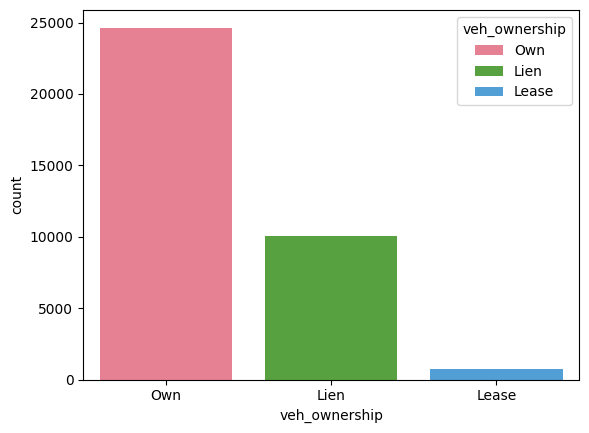

In [10]:
sb.countplot(
    data = data_tr,
    x = "veh_ownership",
    hue = "veh_ownership",
    palette = "husl"
)

<Axes: xlabel='veh_make', ylabel='count'>

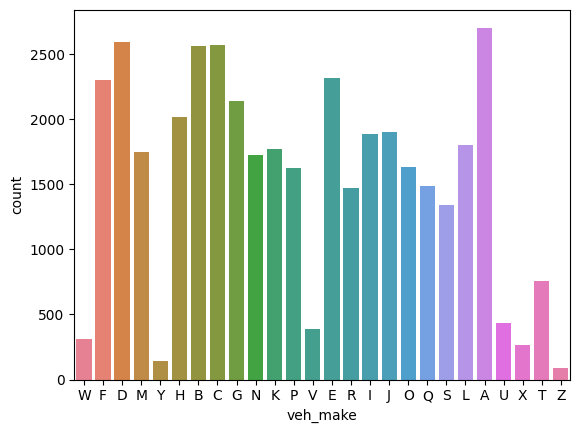

In [11]:
sb.countplot(
    data = data_tr,
    x = "veh_make",
    hue = "veh_make",
    palette = "husl"
)

<Axes: xlabel='veh_model', ylabel='count'>

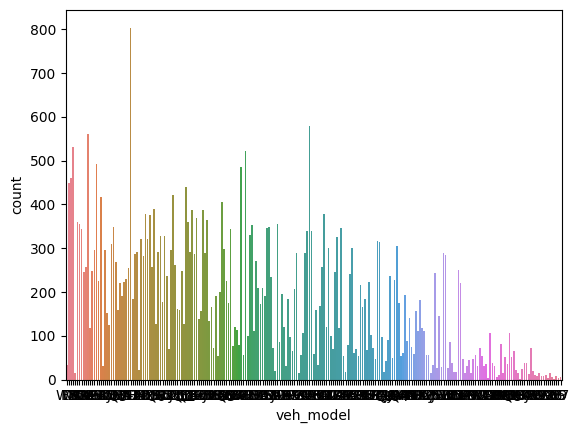

In [12]:
sb.countplot(
    data = data_tr,
    x = "veh_model",
    hue = "veh_model",
    palette = "husl"
)

In [13]:
data_tr["veh_model"].value_counts()

veh_model
A1    804
C1    580
B1    560
M1    531
A2    522
     ... 
Z9      4
Y9      4
Z8      3
X7      2
X8      1
Name: count, Length: 233, dtype: int64

There are 233 different vehicle models. One hot encoding these categorical features can become massive in memory. Given how sparse this would become and the low number of positive class examples, we can exclude this feature from the baseline model. Alternatively, we can include this feature in the model while using an L2 penalty, which is preferable for sparse training data.

<Axes: xlabel='prior_insurer', ylabel='count'>

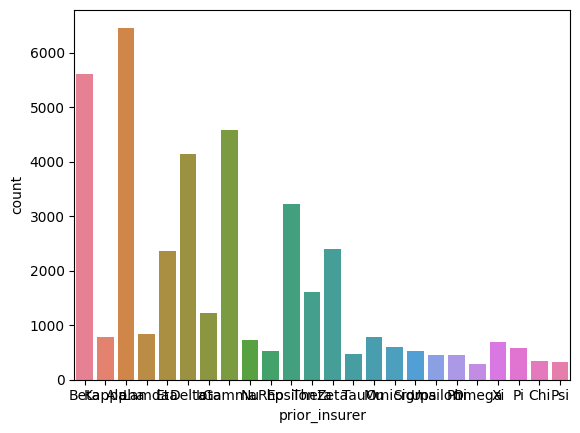

In [14]:
sb.countplot(
    data = data_tr,
    x = "prior_insurer",
    hue = "prior_insurer",
    palette = "husl"
)

In [15]:
data_tr["prior_insurer"].value_counts()

prior_insurer
Alpha      6464
Beta       5603
Gamma      4581
Delta      4146
Epsilon    3226
Zeta       2401
Eta        2366
Theta      1617
Iota       1217
Lamda       836
Kappa       789
Mu          776
Nu          727
Xi          692
Omicron     591
Pi          583
Rho         532
Sigma       520
Tau         476
Upsilon     459
Phi         448
Chi         348
Psi         319
Omega       283
Name: count, dtype: int64

#### Data Preprocess

Split into training and validation sets. The validation set is for plotting the calibration curves of the models. The final models used for estimating test set probabilities will use all of the available data for training. Categorical columns are one hot encoded. Missing floating point values are filled in using median imputation and a dummy variable column is created to account for the missingness incase the data is MNAR.

In [16]:
TARGET_COL = "future_clm_ind"

DROP_COLS = [
    "index",
    "sample",
    "plcy_id",
    "future_clm_ind",
    "Unnamed: 0"
]

Ytr = data_tr[TARGET_COL]
Yte = pd.DataFrame(data_te["plcy_id"].copy())
Xtr = data_tr.drop(columns = DROP_COLS)
Xte = data_te.drop(columns = DROP_COLS)

# Categorical column names after drop columns are excluded.
CAT_COLS = Xtr.select_dtypes(include = "object").columns

# Replace any missing categories.
Xtr_cat = Xtr[CAT_COLS].copy().fillna(value = "missing")
Xte_cat = Xte[CAT_COLS].copy().fillna(value = "missing")
# Fit one hot encoder to categorical columns.
enc = OneHotEncoder().fit(Xtr_cat)
col_names = enc.get_feature_names_out()
Xtr_cat = enc.transform(Xtr_cat).toarray()
Xte_cat = enc.transform(Xte_cat).toarray()

Xtr = pd.concat([Xtr.drop(columns = CAT_COLS),
                 pd.DataFrame(Xtr_cat, columns = col_names)],
                axis = 1)

Xte = pd.concat([Xte.drop(columns = CAT_COLS),
                 pd.DataFrame(Xte_cat, columns = col_names)],
                axis = 1)

# Use median imputation for missing floating point values.
imp = SimpleImputer(
    missing_values = np.nan, 
    strategy = "median",
    add_indicator = True
)

imp.fit(Xtr)
Xtr = imp.transform(Xtr)
Xte = imp.transform(Xte)
column_names = imp.get_feature_names_out()

# Given the class imbalance, use stratified split.
skf = StratifiedKFold(n_splits = 5)

Xtr, Xva, Ytr, Yva = train_test_split(
    Xtr,
    Ytr,
    test_size = 0.2,
    stratify = Ytr
)

del Xtr_cat, Xte_cat

Xtr.shape, Xte.shape

((32000, 341), (20000, 341))

#### Baseline Logistic Regression Model
Use a logistic regression with an L2 (ridge) penalty. As an aside, using an L2 penalty is preferable when the inputs are sparse. Stratified k-fold cross validation is used for model hyper parameter selection. Given the class imbalance, it is important to stratify on the binary target class so that the positive class is equally represented across the cv folds.

In [17]:
# Grid of potential inverse L2 penalty parameters.
L2_grid = {"C": [1e-04, 1e-03, 1e-02, 1e-01, 1]}

reg_model = LogisticRegression(
    penalty = "l2",
    solver = "liblinear",
    max_iter = 100000,
    verbose = 0
)

gscv = GridSearchCV(
    reg_model,
    scoring = make_scorer(
        roc_auc_score,
        needs_proba = True
    ),
    param_grid = L2_grid,
    n_jobs = 1,
    cv = skf.split(Xtr, Ytr)
)

# Run grid search cross validation.
gscv.fit(Xtr, np.array(Ytr).ravel())

GridSearchCV(cv=<generator object _BaseKFold.split at 0x290956d50>,
             estimator=LogisticRegression(max_iter=100000, solver='liblinear'),
             n_jobs=1, param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1]},
             scoring=make_scorer(roc_auc_score, needs_proba=True))

In [18]:
gscv.best_score_

0.663667953730841

In [19]:
gscv.best_params_

{'C': 0.001}

#### Feature Importances

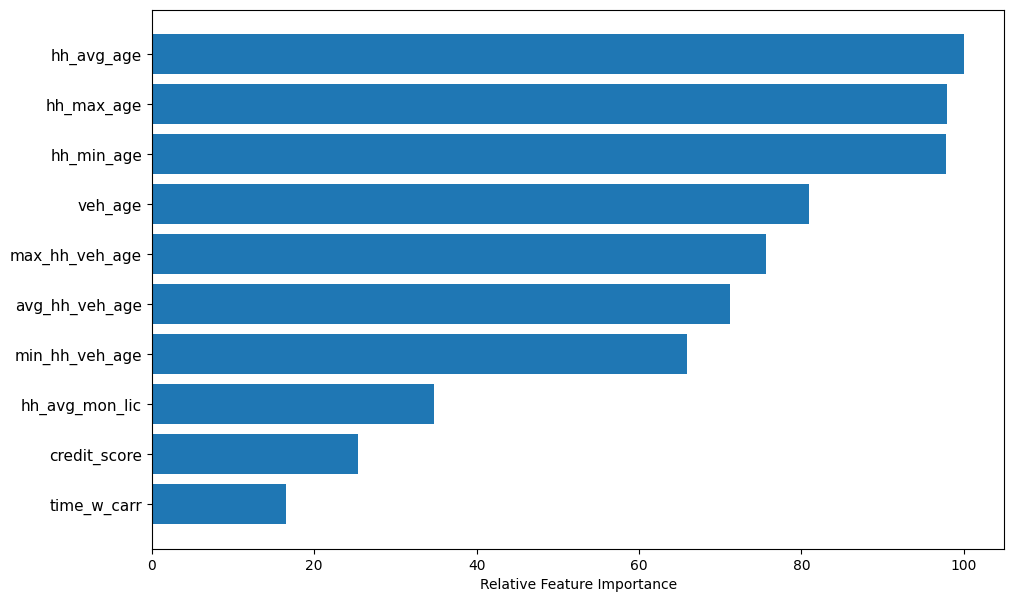

In [21]:
column_names = imp.get_feature_names_out()
fi = abs(gscv.best_estimator_.coef_)[0] # Absolute value of coefficient estimates.
fi = (fi / fi.max()) * 100.0 # Scale by largest value.
idx = np.argsort(fi)[-10:] # Sort by relative importance and subset top 10.
pos = np.arange(idx.shape[0]) + .5
fig = plt.figure()
fig.set_size_inches(11, 7)
ax = fig.add_subplot(1, 1, 1)
ax.barh(pos, fi[idx], align = "center")
ax.set_yticks(pos)
ax.set_yticklabels(np.array(column_names)[idx], fontsize = 11)
ax.set_xlabel("Relative Feature Importance")
plt.show()

In [23]:
gscv.best_estimator_.coef_[0][idx]

array([-0.00081854, -0.00126121, -0.00172608, -0.00327427, -0.0035363 ,
       -0.00375309, -0.00401692, -0.00485747, -0.00486539, -0.00496558])

In [24]:
Y_pred = gscv.best_estimator_.predict_proba(Xva)[:, 1]
cc_y, cc_x = calibration_curve(
    y_true = Yva,
    y_prob = Y_pred,
    n_bins = 10
)

Use the optimal L2 hyperparameter from grid search cross validation to train a calibrated classifier. Then use this trained classifier to visualize the learning curves across different data set sizes to help diagnose potential issues from bias or variance.

In [25]:
# Use optimal C parameter from grid search.
reg_model = LogisticRegression(
    C = gscv.best_params_["C"],
    penalty = "l2",
    solver = "liblinear",
    max_iter = 100000,
    verbose = 0
)

# Use Platt Scaling for calibration of model.
reg_model_calibrated = CalibratedClassifierCV(
    estimator = reg_model,
    method = "sigmoid",
    ensemble = True,
    n_jobs = -1
)

train_sizes, train_scores, valid_scores = learning_curve(
    reg_model_calibrated,
    Xtr,
    np.array(Ytr).ravel(),
    train_sizes = np.linspace(0.2, 1, 20),
    cv = skf.split(Xtr, Ytr),
    scoring = make_scorer(
        roc_auc_score,
        needs_proba = True
    )
)

# Average precision score across the cross validation folds.
train_scores = [np.mean(m) for m in train_scores]
valid_scores = [np.mean(m) for m in valid_scores]

#### Visualize Baseline Learning Curves

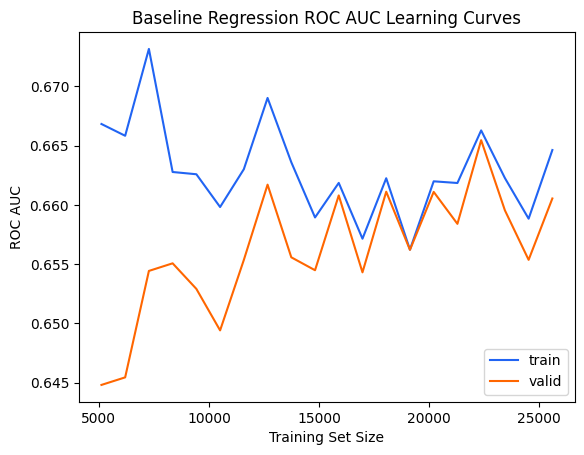

In [26]:
# Training and validation ROC AUC learning curves.
plt.plot(train_sizes, train_scores, color = "#2164F3")
plt.plot(train_sizes, valid_scores, color = "#FF6600")
plt.title(f"Baseline Regression ROC AUC Learning Curves")
plt.ylabel(f"ROC AUC")
plt.xlabel("Training Set Size")
plt.legend(["train", "valid"],
           loc = "lower right")
plt.show()

The variance gap doesn't seem too large but the average precision is really low. It seems like gathering more data would improve the performance slightly as the learning curves have not flattened out as the training set size is increased.

In [27]:
reg_model_calibrated = CalibratedClassifierCV(
    estimator = reg_model,
    method = "sigmoid",
    ensemble = True,
    n_jobs = -1,
    cv = skf.split(Xtr, Ytr)
)
reg_model_calibrated.fit(
    Xtr,
    np.array(Ytr).ravel()
)

# Create a calibration plot to visualize probability calibration.
Y_pred_c = reg_model_calibrated.predict_proba(Xva)[:, 1]
cc_cal_y, cc_cal_x = calibration_curve(
    y_true = Yva,
    y_prob = Y_pred_c,
    n_bins = 10
)

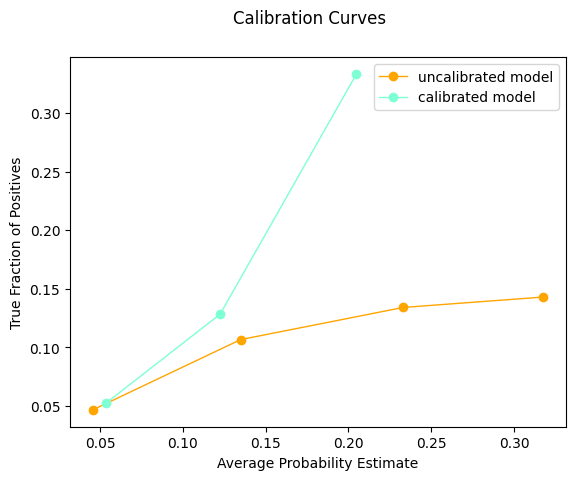

In [28]:
fig, ax = plt.subplots()
plt.plot(cc_x, 
         cc_y, 
         marker = "o", 
         linewidth = 1, 
         color = "orange",
         label = "uncalibrated model")

plt.plot(cc_cal_x, 
         cc_cal_y, 
         marker = "o", 
         linewidth = 1,
         color = "aquamarine",
         label = "calibrated model")

fig.suptitle("Calibration Curves")
ax.set_xlabel("Average Probability Estimate")
ax.set_ylabel("True Fraction of Positives")
plt.legend()
plt.show()

#### Performance
Generate the performance metrics of the calibrated baseline logistic regression model using the average ROC AUC over the stratified cross validation folds. This should give a reasonable expectation of the test set performance. Use all of the available data for training.

In [29]:
# Combine training and validation into a single data set.
Xtr = np.vstack((Xtr, Xva))
Ytr = pd.concat([Ytr, Yva])

Xtr.shape, Ytr.shape

((40000, 341), (40000,))

In [30]:
reg_model_calibrated = CalibratedClassifierCV(
    estimator = reg_model,
    method = "sigmoid",
    ensemble = True
)

cv_score_baseline = cv_score(
    reg_model_calibrated,
    Xtr,
    np.array(Ytr).ravel(),
    cv = skf.split(Xtr, Ytr),
    scoring = make_scorer(
        roc_auc_score,
        needs_proba = True
    ),
    n_jobs = -1
)

In [31]:
print(f"The expected ROC AUC from the baseline model is { round(np.mean(cv_score_baseline), 3) }.")

The expected ROC AUC from the baseline model is 0.662.


#### Test Set Predictions

In [32]:
# Train models using all available data.
reg_model_calibrated.fit(Xtr, np.array(Ytr).ravel())

pred_baseline = reg_model_calibrated.predict_proba(Xte)[:, 1]
Yte["glm_pred"] = np.round(pred_baseline, 4)

# Append the probabilities to the plcy_id in Yte and save as a csv.
Yte.to_csv(
    DATA_PATH + "DS_Work_Sample_Scored.csv",
    index = False,
    header = True
)